In [ ]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/dataset' '/content/sample_data' 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import os

dataset_path = os.listdir('/content/sample_data/dataset')

disease_types = os.listdir('/content/sample_data/dataset')
#print (room_types)  #what kinds of rooms are in this dataset

print("Types of disease found: ", len(dataset_path))

Types of disease found:  7


In [ ]:
disease_types

['tomato_mosaic',
 'septoriaLeafSpot',
 'bacterialSpot',
 'leaf_Moldmanual',
 'lateblight',
 'yellowcurved',
 'Healthy']

In [ ]:

diseases = []

for item in disease_types:
# Get all the file names
     all_diseases = os.listdir('/content/sample_data/dataset' + '/' +item)
     #print(all_shoes)

     # Add them to the list
     for disease in all_diseases:
        diseases.append((item, str('/content/sample_data/dataset' + '/' +item) + '/' + disease))
        #print(rooms[:1])

In [ ]:

import cv2
path = '/content/sample_data/dataset/'

im_size = 100

images = []
labels = []

for i in disease_types:
    data_path = path + str(i)  # entered in 1st folder and then 2nd folder and then 3rd folder
    filenames = [i for i in os.listdir(data_path) ]
   # print(filenames)  # will get the names of all images
    for f in filenames:
        try: 
            img = cv2.imread(data_path + '/' + f)  # reading that image as array
            #print(img)  # will get the image as an array
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(i)
        except Exception as e:
                print(e)

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
images = np.array(images)
images = images.astype('float32') / 255.0

In [ ]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=np.array(labels)
#print(y[:5])

# for y
y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y.shape)

y=y.reshape(-1,1)
# print(y.shape, type(y))
onehotencoder = OneHotEncoder(sparse=False)  #Converted  scalar output into vector output where the correct class will be 1 and other will be 0
Y= onehotencoder.fit_transform(y)
Y.shape  #(393, 3)

(6355,)


(6355, 7)

In [ ]:
type(Y)

numpy.ndarray

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)

train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(6037, 100, 100, 3)
(6037, 7)
(318, 100, 100, 3)
(318, 7)


In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

# SENet

In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
def SqueezeAndExcitation(inputs, ratio=8):
    b, l, h, c = inputs.shape
    t = inputs
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation="relu", use_bias=False)(x)
    x = Dense(c, activation="sigmoid", use_bias=False)(x)
    x = inputs * x[0]
    return x

# Identity Block

In [ ]:
# x is input, y=F(x)
# identity block simply means input should be equal to output. 
#  y = x + F(x)   the layers in a traditional network are learning the true output H(x)
# F(x) = y - x   the layers in a residual network are learning the residual F(x)
# Hence, the name: Residual Block.



def identity_block(X, f, filters, stage, block , se = False):
    """
   
    Arguments:
    X -- input of shape (m, height, width, channel)
    f -- shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Saving the input value.we need this later to add to the output. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    if(se):
      X = SqueezeAndExcitation(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

# Convolution Block

In [ ]:

def convolutional_block(X, f, filters, stage, block, s = 2):
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    # First layer 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X) # 1,1 is filter size
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)  # normalization on channels
    X = Activation('relu')(X)

      
    # Second layer  (f,f)=3*3 filter by default
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third layer
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value here, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
p = SqueezeAndExcitation(train_x, 1)
p.shape

TensorShape([6037, 100, 100, 3])

# ResNet-50

In [ ]:
#Each ResNet block is either 2 layer deep
def ResNet50(input_shape=(64, 64, 3), classes=3):
    """
    Implementation of the ResNet50 architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) #3,3 padding

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X) #64 filters of 7*7 
    X = BatchNormalization(axis=3, name='bn_conv1')(X) #batchnorm applied on channels
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X) #window size is 3*3

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    # convolutional_block is a function defined above. Convolutional_block have 3 layers.
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b') 
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c', se = True)



    ### START CODE HERE ###

    # Stage 3 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d', se = True)

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f', se = True)

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c', se = True)

    # AVGPOOL 
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [ ]:
model = ResNet50(input_shape = (100, 100, 3), classes = 7)

In [ ]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(images, Y, epochs = 10, batch_size = 32, validation_split=0.1, callbacks=[model_checkpoint_callback]) 

Epoch 1/10
179/179 [==============================] - 37s 125ms/step - loss: 0.7222 - accuracy: 0.7627 - val_loss: 8.0545 - val_accuracy: 0.1022
Epoch 2/10
179/179 [==============================] - 19s 107ms/step - loss: 0.2628 - accuracy: 0.9136 - val_loss: 9.3415 - val_accuracy: 0.1116
Epoch 3/10
179/179 [==============================] - 19s 107ms/step - loss: 0.1608 - accuracy: 0.9409 - val_loss: 3.0776 - val_accuracy: 0.3569
Epoch 4/10
179/179 [==============================] - 19s 109ms/step - loss: 0.1282 - accuracy: 0.9582 - val_loss: 0.6495 - val_accuracy: 0.8412
Epoch 5/10
179/179 [==============================] - 19s 106ms/step - loss: 0.0979 - accuracy: 0.9671 - val_loss: 0.4773 - val_accuracy: 0.8962
Epoch 6/10
179/179 [==============================] - 19s 104ms/step - loss: 0.0570 - accuracy: 0.9815 - val_loss: 0.1133 - val_accuracy: 0.9670
Epoch 7/10
179/179 [==============================] - 19s 106ms/step - loss: 0.0346 - accuracy: 0.9872 - val_loss: 0.1049 - val_ac

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/checkpoint')

In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 1s 79ms/step - loss: 0.0262 - accuracy: 0.9937
Loss = 0.02618229389190674
Test Accuracy = 0.9937106966972351


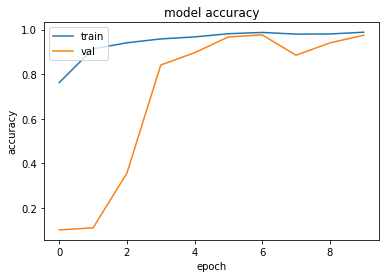

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

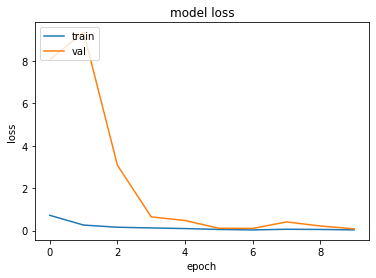

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
p = model.predict([test_x])

10/10 [==============================] - 1s 36ms/step


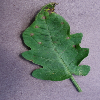

actual output : 4
prediction : 4
lateblight


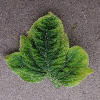

actual output : 6
prediction : 6
Healthy


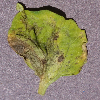

actual output : 4
prediction : 4
lateblight


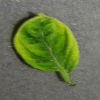

actual output : 6
prediction : 6
Healthy


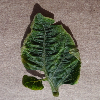

actual output : 6
prediction : 6
Healthy


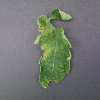

actual output : 2
prediction : 2
bacterialSpot


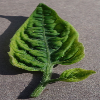

actual output : 6
prediction : 6
Healthy


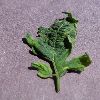

actual output : 5
prediction : 5
yellowcurved


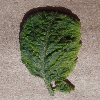

actual output : 6
prediction : 6
Healthy


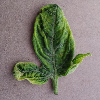

actual output : 6
prediction : 6
Healthy


In [ ]:
for i in range(200, 210):
  cv2_imshow(test_x[i]*255.0)
  print('actual output : '+ str(np.argmax(test_y[i])))
  print('prediction : '+ str(np.argmax(p[i])))
  print(disease_types[np.argmax(p[i])])


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/final_model1')

In [ ]:
import keras
load_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/final_model1')

In [ ]:
preds = load_model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

10/10 [==============================] - 1s 39ms/step - loss: 0.0262 - accuracy: 0.9937
Loss = 0.02618229389190674
Test Accuracy = 0.9937106966972351
